In [1]:
import pandas as pd
import xgboost
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso, Ridge
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, accuracy_score, precision_score, recall_score, precision_recall_curve, roc_curve, roc_auc_score
import matplotlib.pyplot as plt
plt.style.use('dark_background')

## Load Data

In [3]:
df = pd.read_csv('../data/interim/full_joined_data.csv')
df.head()

,Unnamed: 0,origin_id,destination_id_01,proximity_kilometers_01,proximity_minutes_01,destination_id_02,proximity_kilometers_02,proximity_minutes_02,destination_id_03,proximity_kilometers_03,...,schoolenrollment_acsgrd9,schoolenrollment_acspubgrd9,schoolenrollment_acsprvgrd9,schoolenrollment_acscollege,schoolenrollment_acspubcoll,schoolenrollment_acsprvcoll,schoolenrollment_acsgrad,schoolenrollment_acspubgrad,schoolenrollment_acsprvgrad,schoolenrollment_acsnotnsch
0,0,410050201001000,998326755,1.548381,3.355589,236771176,1.716985,3.834511,731023672,1.776342,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,410050201001001,998326755,1.358351,2.816526,236771176,1.526954,3.295449,731023672,1.586312,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,410050201001002,998326755,1.683183,3.781076,236771176,1.851786,4.259999,731023672,1.911143,...,2.0,2.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,27.0
3,3,410050201001003,998326755,1.480122,3.140135,236771176,1.648726,3.619058,731023672,1.708083,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,410050201001004,998326755,1.577137,2.642447,236771176,1.745741,3.121370,731023672,1.805098,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0


## Select Features
We only select the promities, the store IDs and the enrichment variables

In [4]:
feature_list = df.columns.tolist()
_ = feature_list.index('groupquarters_gqpop_cy')
enrichment_variables = feature_list[_:]
other_variables = [f for f in feature_list[:_] if '_id' not in f and 'trip_count' not in f]
other_variables = list(set(other_variables) - {'Unnamed: 0'})

In [5]:
enrichment_variables[:5]

['groupquarters_gqpop_cy',
 'generations_genalphacy',
 'generations_genz_cy',
 'generations_millenn_cy',
 'generations_genx_cy']

In [6]:
other_variables[:5]

['store_name_category_01_UNCLE_GARYS_COFFEE_EMPORIUM',
 'store_name_category_04_HUMAN_BEAN',
 'store_name_category_01_JIM_PATTYS_COFFEE',
 'store_name_category_01_BLUE_MOON_COFFEE',
 'store_name_category_02_UNCLE_GARYS_COFFEE_EMPORIUM']

In [7]:
# All feature columns
features = other_variables + enrichment_variables

In [8]:
# Pearson correlation between variables
from scipy.stats import pearsonr
R = np.array([pearsonr(df.loc[:,'trip_count_01'] ,df.loc[:,c])[0] for c in enrichment_variables])

In [9]:
idx = np.argsort(R)
print(np.sort(R)[::-1][:50])

[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan]


We see a lot of correlations, nothing other ~22%. It'll have to be the combination that gives any reasonable preditive power

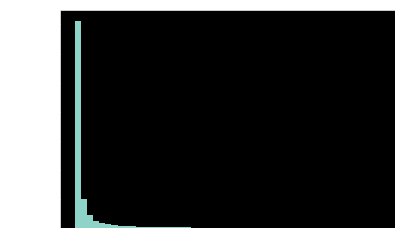

In [10]:
df.trip_count_01.plot.hist(range(51))

In [11]:
df.loc[:,'log_trip_count'] = np.log10(df.trip_count_01 + 1)

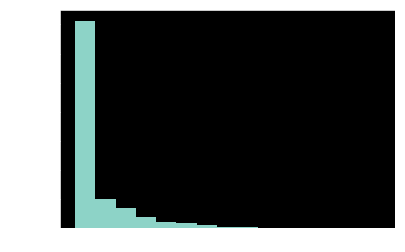

In [12]:
df.log_trip_count.plot.hist(15)

By far, the majority are zeros. Since most blocks DON'T visit a coffee shop, it makes sense to look at this initially as a binary classification problem:
Will a block visit this coffee shop?

This could potentially be done as a regression problem with the logarithm (power of ten in this case) of visits. The order of magnitude is more more useful than the exact count anyway.

In [13]:
df.trip_count_01.describe()

count    48553.000000
mean         1.610570
std         10.884486
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max       1616.000000
Name: trip_count_01, dtype: float64

In [14]:
df.trip_count_01.median()

0.0

The max is MUCH higher than the mean, and the median is zero. It doesn't make sense to use regression on the counts for this as the problem is framed. 

In [15]:
X = df.loc[:,features]

In [18]:
# Binary classification target
y_c = df.loc[:,'trip_count_01'].values > 0
# Log regression target
y_r = df.loc[:,'log_trip_count'].values 

C:\Program Files\ArcGIS\Pro\bin\Python\envs\arcgis\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater
  


In [19]:
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X.values, y_c, test_size=0.25, random_state=42)
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(X.values, y_r, test_size=0.25, random_state=42)

In [20]:
np.mean(y_train_c),np.mean(y_test_c)

(0.2655773719621035, 0.2664140374001153)

In [21]:
np.mean(y_train_r),np.mean(y_test_r)

(nan, 0.16547013841934952)

In [22]:
xg_c = (
    xgboost.XGBClassifier(n_estimators=1000, learning_rate=0.1)
        .fit(
            X_train_c, 
            y_train_c, 
            eval_set=[(X_test_c,y_test_c)], 
            eval_metric='auc',
            early_stopping_rounds=20
        )
)

[0]	validation_0-auc:0.771813
Will train until validation_0-auc hasn't improved in 20 rounds.
[1]	validation_0-auc:0.783496
[2]	validation_0-auc:0.79027
[3]	validation_0-auc:0.791272
[4]	validation_0-auc:0.791117
[5]	validation_0-auc:0.793807
[6]	validation_0-auc:0.795573
[7]	validation_0-auc:0.79656
[8]	validation_0-auc:0.798045
[9]	validation_0-auc:0.798228
[10]	validation_0-auc:0.798421
[11]	validation_0-auc:0.800001
[12]	validation_0-auc:0.800246
[13]	validation_0-auc:0.80066
[14]	validation_0-auc:0.800996
[15]	validation_0-auc:0.801338
[16]	validation_0-auc:0.804003
[17]	validation_0-auc:0.804482
[18]	validation_0-auc:0.805592
[19]	validation_0-auc:0.805602
[20]	validation_0-auc:0.805653
[21]	validation_0-auc:0.806532
[22]	validation_0-auc:0.807542
[23]	validation_0-auc:0.807604
[24]	validation_0-auc:0.808073
[25]	validation_0-auc:0.808958
[26]	validation_0-auc:0.809967
[27]	validation_0-auc:0.810247
[28]	validation_0-auc:0.810332
[29]	validation_0-auc:0.811101
[30]	validation_0-a

In [23]:
# Classification probabilities
yp_test_c = xg_c.predict_proba(X_test_c)[:,1]
yp_train_c = xg_c.predict_proba(X_train_c)[:,1]

In [24]:
yp_test_c

array([0.2751202 , 0.00112139, 0.05576888, ..., 0.13151364, 0.00524749,
       0.15276636], dtype=float32)

In [25]:
print("Accuracy (Train):", accuracy_score(y_train_c, yp_train_c > 0.5))
print("Accuracy (Test):", accuracy_score(y_test_c, yp_test_c > 0.5))
print("Precision (Train):", precision_score(y_train_c, yp_train_c > 0.5))
print("Precision (Test):", precision_score(y_test_c, yp_test_c > 0.5))
print("Recall (Train):", recall_score(y_train_c, yp_train_c > 0.5))
print("Recall (Test):", recall_score(y_test_c, yp_test_c > 0.5))
print("ROC AUC (Train)", roc_auc_score(y_train_c, yp_train_c))
print("ROC AUC (Test)", roc_auc_score(y_test_c, yp_test_c))

Accuracy (Train): 0.8562680214197446
Accuracy (Test): 0.8140703517587939
Precision (Train): 0.8272606579141466
Precision (Test): 0.7139728427507666
Recall (Train): 0.5798779857305346
Recall (Test): 0.5040197897340755
ROC AUC (Train) 0.9064998451290966
ROC AUC (Test) 0.8557163205234113


In [26]:
prec_te,rec_te,thres = precision_recall_curve(y_test_c, yp_test_c)
prec_tr,rec_tr,thres = precision_recall_curve(y_train_c, yp_train_c)

In [27]:
fpr_te,tpr_te,thres = roc_curve(y_test_c, yp_test_c)
fpr_tr,tpr_tr,thres = roc_curve(y_train_c, yp_train_c)

Text(0.5,0,'False Positive Rate')

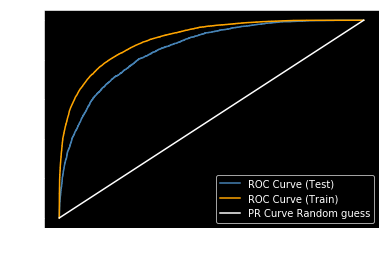

In [28]:
plt.figure()
plt.plot(fpr_te,tpr_te,'-',color='steelblue', label="ROC Curve (Test)")
plt.plot(fpr_tr,tpr_tr,'-',color='orange', label="ROC Curve (Train)")
plt.plot([0,1],[0,1],'w-', label='PR Curve Random guess')
plt.legend()
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

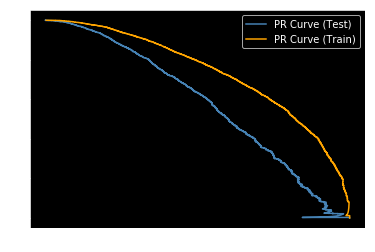

In [29]:
plt.figure()
plt.plot(prec_te,rec_te,'-',color='steelblue', label="PR Curve (Test)")
plt.plot(prec_tr,rec_tr,'-',color='orange', label="PR Curve (Train)")
plt.legend()

In [30]:
print(np.sum(xg_c.feature_importances_ > 0))

682


In [37]:
idx = np.argsort(xg_c.feature_importances_)
idx[-50:]

array([1284,    4,  377,   33,  396,  112,  168,  277,  946,  318,   48,
        185,  333,  224,   62,  388,   81,   40,  732,  442,  376, 1158,
       1037,  575,  303,    6,   19,   86,  883,  370,  531,  765, 1012,
        601,  173,   66,  326,   25,   27,  440, 1159,   39,   82,  330,
        290,  220, 1273, 1274,  439, 1160], dtype=int64)

In [32]:
np.array(features)[idx][-50:]

array(['schoolenrollment_acsgrd1',
       'store_name_category_02_UNCLE_GARYS_COFFEE_EMPORIUM',
       'networth_aggnwa35cy',
       'store_name_category_03_DUTCH_BROTHERS_COFFEE',
       'networth_a55nw250cy', 'gender_pop60_cy',
       'householdtype_stepchfh10', 'disposableincome_aggdia45cy',
       'agebyracebysex_hsp10_cy', 'householdincome_hinc0_cy',
       'store_name_category_01_HUMAN_BEAN', 'householdtype_p65parnt10',
       'networth_nw0_cy', 'disposableincome_avgdi_cy',
       'store_name_category_02_ALLEGRO_COFFEE', 'networth_aggnwa45cy',
       'store_name_category_02_GAIA_JAVA', 'proximity_kilometers_04',
       'agebyracebysex_asnm35_cy', 'wealth_medval_cy',
       'networth_avgnwa35cy', 'keyusfacts_divindx_cy',
       'heatingfuel_acsutlgas', 'agebyracebysex_whtf40_cy',
       'disposableincome_aggdia65cy',
       'store_name_category_03_BLUE_MOON_COFFEE',
       'store_name_category_02_BLUE_MOON_COFFEE',
       'proximity_kilometers_03', 'agebyracebysex_othfbasecy',
   

In [35]:
range(50),xg_c.feature_importances_[idx][-50:]

(range(0, 50),
 array([0.00224428, 0.0022505 , 0.00225091, 0.0022935 , 0.00229747,
        0.00230845, 0.00237835, 0.00245051, 0.00245578, 0.00245912,
        0.00249492, 0.00262127, 0.00264321, 0.00265419, 0.00274759,
        0.00280271, 0.00281507, 0.00292011, 0.00296967, 0.00299931,
        0.00301175, 0.00304997, 0.00305471, 0.00328654, 0.00332739,
        0.00337204, 0.00341018, 0.00344331, 0.00344511, 0.00381412,
        0.00387296, 0.00409598, 0.00491309, 0.00520484, 0.0054987 ,
        0.00608067, 0.00628613, 0.0064492 , 0.00751614, 0.00757066,
        0.00823563, 0.01002255, 0.01006569, 0.01354158, 0.01742801,
        0.0182555 , 0.02040813, 0.02187441, 0.0255848 , 0.03213197],
       dtype=float32))

Text(0.5,1,'Feature Importance (Weight Importance)')

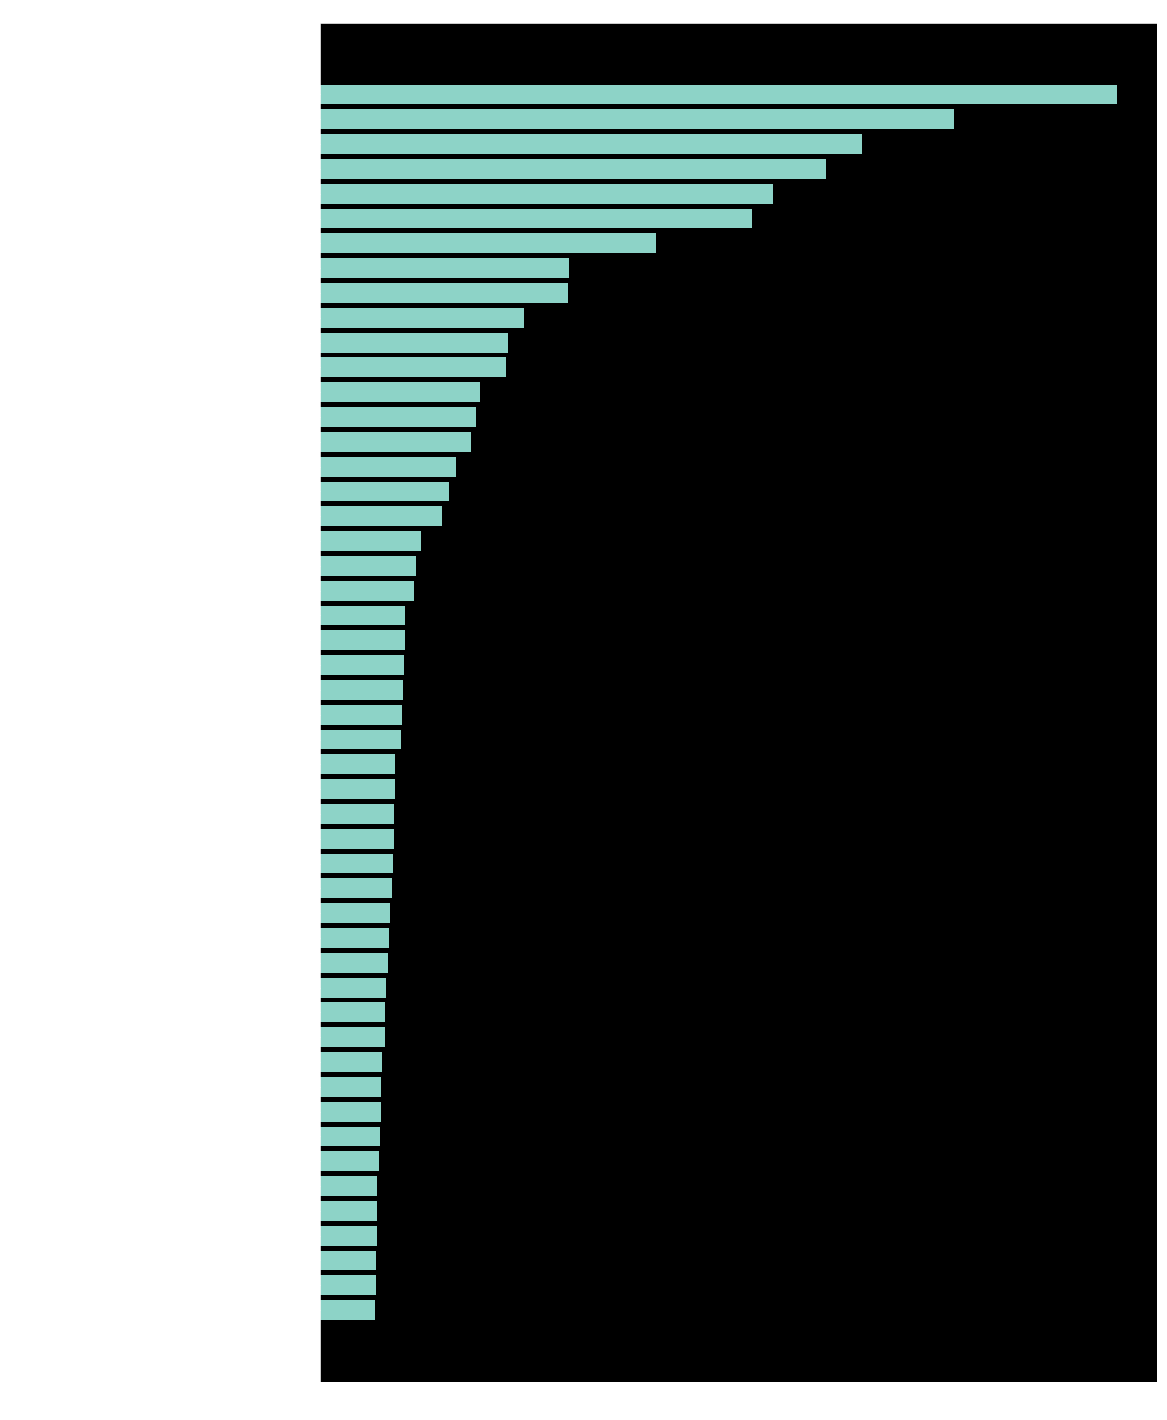

In [34]:
plt.figure(figsize=(15,25))
plt.barh(range(50),xg_c.feature_importances_[idx][-50:])
_ =plt.yticks(range(50),list(np.array(features)[idx][-50:]))
plt.xlabel("Feature Importance (Weight Importance)")
plt.title("Feature Importance (Weight Importance)")

In [ ]:
xg_r = xgboost.XGBRegressor(n_estimators=1000, learning_rate=0.1).fit(X_train_r, y_train_r, eval_set=[(X_test_r, y_test_r)],eval_metric='rmse',early_stopping_rounds=20)

In [ ]:
# Regression values
yp_test_r = xg_r.predict(X_test_r)
yp_train_r = xg_r.predict(X_train_r)

In [ ]:
print(r2_score(y_test_r, yp_test_r))
print(r2_score(y_train_r, yp_train_r))

In [ ]:
plt.scatter(10**yp_test_r, 10**y_test_r, color='r')

In [ ]:
plt.scatter(10**yp_train_r, 10**y_train_r, color='r')

In [ ]:
idxr = np.argsort(xg_r.feature_importances_)

plt.figure(figsize=(15,25))
plt.barh(range(50),xg_r.feature_importances_[idxr][-50:])
plt.yticks(range(50),labels=list(np.array(features)[idx][-50:]))